In [1]:
import matplotlib.pyplot as plt
import numpy as np
from time import localtime, strftime
import seaborn as sns
import torch
import torch.utils.data as torch_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import wfdb
import pandas as pd
from pdb import set_trace as bp

In [2]:
data_dir = '/media/l7/data_storage1/datasets/afib_dataset/training2017/'

In [3]:
targets = pd.read_csv(data_dir + 'REFERENCE_mod.csv', )

In [7]:
data = wfdb.rdrecord(data_dir + 'A00003')


# General Information

## Introduction
This dataset derives from the Physionet AFIB challenge. Atrial Fibrillation is an arrhythmia that may be classified by observing periods of 30-60 seconds of patients ECG. The records here show normal sinus rhythms (N), AFIB, alternative rhythm (A), Other (O), or too noisy to be classified rhythms (~). 

## Approach 

First we will process all of the recordings, and place them into a single pandas dataframe. This will make it easier to create batches, feed the data later. Part of this preprocessing work will also include adding the FFT of the input. 

Next, we will import define a model, whose first layer will be an LSTM. The goal is to be able to handle these variable lengths input parameters. We will then experiment with different architectures. 

Finally, we will produce classification results, based on a separate test set. 


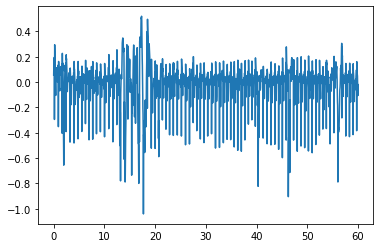

In [8]:
plt.plot(np.arange(data.sig_len) / data.fs, data.p_signal)
plt.show()

In [9]:
def get_fft(data, absolute_value=True):
    """
    Compute the fft for a specific input dataset.
    :param data:
    :param absolute_value:
    :return:
    """
    fft_data = np.fft.fft(data, axis=0) * 1/len(data)
    if not absolute_value:
        return fft_data
    else:
        abs_fft_data = abs(fft_data[:int(len(fft_data) / 2)])
        return abs_fft_data

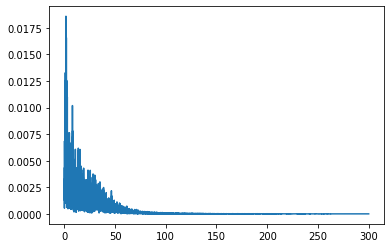

In [10]:
data_fft = get_fft(data.p_signal, absolute_value=True)
plt.plot(np.linspace(0, data.fs, num=len(data_fft)), data_fft)
plt.show()

## Label Mapping: 
N -> 0

A -> 1

O -> 2

~ -> 3

In [11]:
def label_mapping(label):
    if label == 'N':
        return 0
    elif label =='A':
        return 1
    elif label =='O': 
        return 2
    else: 
        return 3

In [12]:
data_df = pd.DataFrame(columns=['record_id', 'raw_data', 
                                'abs_fft', 'label', 
                                'signal_length'])
for index, row in targets.iterrows():
    record = wfdb.rdrecord(data_dir + row['record_id'])
    data_df.loc[data_df.index.size] = [row['record_id'],
                                       record.p_signal,
                                       get_fft(record.p_signal),
                                       label_mapping(row['label']),
                                       record.sig_len
                                      ]

In [14]:
data_df.to_pickle(data_dir + 'validation_data_df.pckl')

In [15]:
data_df

,record_id,raw_data,abs_fft,label,signal_length
0,A00001,"[[-0.127], [-0.162], [-0.197], [-0.229], [-0.2...","[[0.018569444444444444], [0.003657007647295172...",0,9000
1,A00002,"[[0.128], [0.157], [0.189], [0.226], [0.25], [...","[[0.021240555555555554], [0.00284763803002752]...",0,9000
2,A00003,"[[0.056], [0.073], [0.085], [0.093], [0.1], [0...","[[0.006789166666666667], [0.002250549586930657...",0,18000
3,A00004,"[[0.519], [0.619], [0.723], [0.827], [0.914], ...","[[0.040544444444444445], [0.007857301803282146...",1,9000
4,A00005,"[[-0.188], [-0.239], [-0.274], [-0.316], [-0.3...","[[0.020819555555555556], [0.002531190703392904...",2,18000
5,A00006,"[[-0.266], [-0.316], [-0.367], [-0.407], [-0.4...","[[0.001286555555555556], [0.001530113740211399...",0,9000
6,A00007,"[[0.021], [0.022], [0.024], [0.026], [0.028], ...","[[0.013701222222222224], [0.001160830913661022...",0,9000
7,A00008,"[[-0.187], [-0.236], [-0.286], [-0.34], [-0.37...","[[0.021979611111111113], [0.000874164915542021...",2,18000
8,A00009,"[[0.051], [0.056], [0.059], [0.063], [0.065], ...","[[0.012716333333333335], [0.004062655434696199...",1,9000
9,A00010,"[[-1.028], [-1.225], [-1.418], [-1.599], [-1.7...","[[0.008469166666666668], [0.002339071500808214...",0,18000


In [16]:
data_df['signal_length'].min()

3002

In [17]:
data_df['signal_length'].max()

18170

In [18]:
data_df['abs_fft'][0].shape

(4500, 1)

In [23]:
data_np = np.zeros([len(data_df), 18286])
fft_data_np = np.zeros([len(data_df), int(18286 / 2)])

for index, row in data_df.iterrows():
#     bp()
    data_np[index, :row['signal_length']] += row['raw_data'].ravel()
    fft_data_np[index, :int(row['signal_length'] / 2)] += row['abs_fft'].ravel()
                       

In [24]:
labels = np.array(data_df['label'], dtype=int)
type(labels)

numpy.ndarray

In [25]:
data_np.shape

(300, 18286)

In [26]:
np.save(data_dir + 'validation_data_np.npy', data_np)
np.save(data_dir + 'validation_fft_data_np.npy', fft_data_np)
np.save(data_dir + 'validation_labels.npy', labels)

## Input Notes

The input x to the model will be a tuple containing the raw signal and the abs_fft version of it. 
Each will be processed by their respective networks within the models. As such, the final datasets will be built with this in mind. 

In [62]:
class GeneralDataset(torch_data.Dataset):
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self,):
        return len(self.data)
    
    def __getitem__(self,index):
        sample = {'signal': torch.tensor(self.data[index]).float(),
                 'label': torch.tensor(self.labels[index]).long()}
        return sample

In [6]:
train_labels = np.load(data_dir + 'labels.npy')

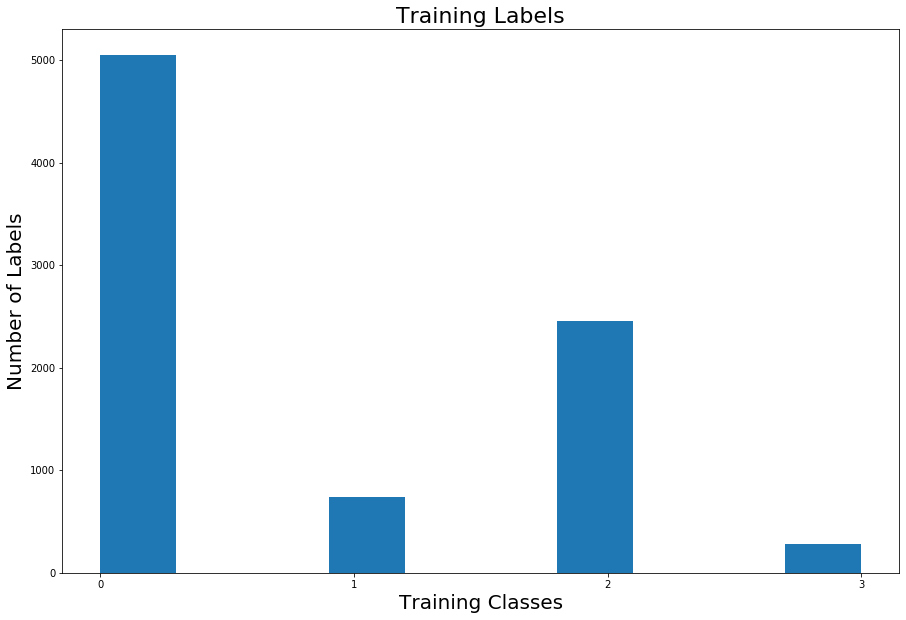

In [15]:
plt.figure(figsize=(15,10))
plt.hist(train_labels)
plt.title('Training Labels', fontsize=22)
plt.xlabel('Training Classes', fontsize=20)
plt.xticks([0, 1, 2, 3])
plt.ylabel('Number of Labels', fontsize=20)
plt.show()